## General utility functions and variables

In [4]:
#import ipyparallel
#ipyclient = ipyparallel.Client()
import matplotlib.pyplot
%matplotlib inline

In [2]:
def setup():
    import sys
    import os
    sys.path.append(os.getcwd())

ipyclient[:].apply_sync(setup)
    
with ipyclient[:].sync_imports(local=True):
    import simulation_utils
    import sys
    import numpy
    import matplotlib.pyplot
    import subprocess
    import networkx
    import os
    import shutil
    import yaml
    import ipyparallel
    from networkx import __version__ as networkxversion

print('networkx: '+networkxversion)

importing simulation_utils on engine(s)
importing sys on engine(s)
importing numpy on engine(s)
importing matplotlib.pyplot on engine(s)
importing subprocess on engine(s)
importing networkx on engine(s)
importing os on engine(s)
importing shutil on engine(s)
importing yaml on engine(s)
importing ipyparallel on engine(s)
importing __version__ from networkx on engine(s)
networkx: 2.2


# Figure 2

## 2a
The x-axis is the number of trees (or landmarks) used, and the y-axis is the ratio of successfully routed transaction to total transactions. Each point on the plot is the value of CREDIT_NETWORK_SUCCESS in _singles.txt for the run with that many trees. All of these runs use 2 attempts.

### Run simulations

In [23]:
attempts = 1
transaction_set = 0
attack = 1
no_attack = 0
for tree in range(1, max_trees+1):
    run_static(transaction_set, silentwhispers, attempts, tree, no_attack)
    run_static(transaction_set, speedymurmurs, attempts, tree, attack, force=True)
print('Done.')

Run exists. Skipping...
Running: java -cp bin/ treeembedding.tests.Static 0 7 1 1 1
Run exists. Skipping...
Running: java -cp bin/ treeembedding.tests.Static 0 7 1 2 1
Run exists. Skipping...
Running: java -cp bin/ treeembedding.tests.Static 0 7 1 3 1
Run exists. Skipping...
Running: java -cp bin/ treeembedding.tests.Static 0 7 1 4 1
Run exists. Skipping...
Running: java -cp bin/ treeembedding.tests.Static 0 7 1 5 1
Run exists. Skipping...
Running: java -cp bin/ treeembedding.tests.Static 0 7 1 6 1
Run exists. Skipping...
Running: java -cp bin/ treeembedding.tests.Static 0 7 1 7 1


### Generate plots from data

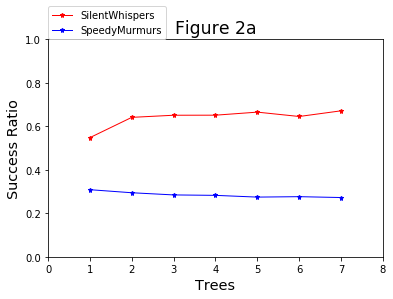

In [25]:
attempts = 1
key = 'CREDIT_NETWORK_SUCCESS'
silentwhispers_data = extract_from_singles(silentwhispers, attempts, max_trees, key)
speedymurmurs_data = extract_from_singles(speedymurmurs, attempts, max_trees, key)

matplotlib.pyplot.figure()
matplotlib.pyplot.title('Figure 2a', size='xx-large')
matplotlib.pyplot.ylabel('Success Ratio', size='x-large')
matplotlib.pyplot.xlabel('Trees', size='x-large')
matplotlib.pyplot.axis([0,8,0.0,1.0])

matplotlib.pyplot.plot(range(1,max_trees+1), silentwhispers_data, 'r*-', markersize=5, linewidth=1, label='SilentWhispers')
matplotlib.pyplot.plot(range(1,max_trees+1), speedymurmurs_data, 'b*-', markersize=5, linewidth=1, label='SpeedyMurmurs')
matplotlib.pyplot.legend(loc=(0,1), scatterpoints=10)


## 2b
The x-axis is the number of trees (or landmarks) used, and the y-axis is the number of hops a transaction took to reach its destination. Each point on the plot is the value of CREDIT_NETWORK_DELAY_AV in _singles.txt for the run with that many trees. All of these runs use 2 attempts.

Same simulations as 2a.


### Generate plots from data

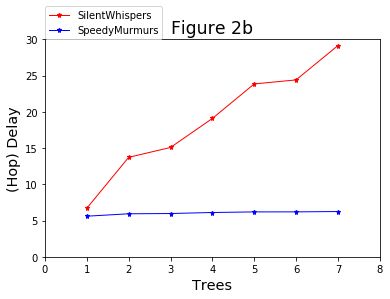

In [21]:
attempts = 1
key = 'CREDIT_NETWORK_DELAY_AV'
silentwhispers_data = extract_from_singles(silentwhispers, attempts, max_trees, key)
speedymurmurs_data = extract_from_singles(speedymurmurs, attempts, max_trees, key)

matplotlib.pyplot.figure()
matplotlib.pyplot.title('Figure 2b', size='xx-large')
matplotlib.pyplot.ylabel('(Hop) Delay', size='x-large')
matplotlib.pyplot.xlabel('Trees', size='x-large')
matplotlib.pyplot.axis([0,8,0,30])

matplotlib.pyplot.plot(range(1,max_trees+1), silentwhispers_data, 'r*-', markersize=5, linewidth=1, label='SilentWhispers')
matplotlib.pyplot.plot(range(1,max_trees+1), speedymurmurs_data, 'b*-', markersize=5, linewidth=1, label='SpeedyMurmurs')
matplotlib.pyplot.legend(loc=(0,1), scatterpoints=10)


## 2c
The x-axis is the number of times a failed transaction should be retried, and the y-axis is the ratio of successfully routed transaction to total transactions. Each point on the plot is the value of CREDIT_NETWORK_SUCCESS in \_singles.txt for the run with that many retries. All of these runs use 3 landmarks.

### Run simulations

In [ ]:
trees = 3
transaction_set = 0
for attempt in range(1, max_attempts+1):
    run_static(transaction_set, silentwhispers, attempt, trees)
    run_static(transaction_set, speedymurmurs, attempt, trees)
print('Done.')  
    

Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Running: java -cp bin/ treeembedding.tests.Static 0 7 8 3


### Generate plots from data

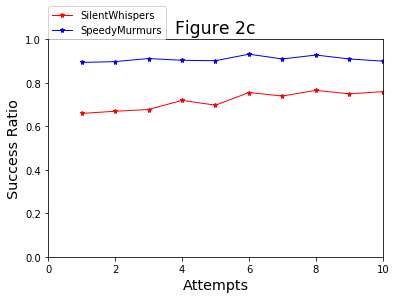

In [23]:
trees = 3
key = 'CREDIT_NETWORK_SUCCESS'
silentwhispers_data = extract_from_singles_attempts(silentwhispers, max_attempts, trees, key)
speedymurmurs_data = extract_from_singles_attempts(speedymurmurs, max_attempts, trees, key)

matplotlib.pyplot.figure()
matplotlib.pyplot.title('Figure 2c', size='xx-large')
matplotlib.pyplot.ylabel('Success Ratio', size='x-large')
matplotlib.pyplot.xlabel('Attempts', size='x-large')
matplotlib.pyplot.axis([0,10,0.0,1.0])

matplotlib.pyplot.plot(range(1,max_attempts+1), silentwhispers_data, 'r*-', markersize=5, linewidth=1, label='SilentWhispers')
matplotlib.pyplot.plot(range(1,max_attempts+1), speedymurmurs_data, 'b*-', markersize=5, linewidth=1, label='SpeedyMurmurs')
matplotlib.pyplot.legend(loc=(0,1), scatterpoints=10)


## Figure 3 Plots

## 3a
This is generated from the Ripple transaction data set, not from the simulator. The x-axis is the epoch number with epochs being of length 1000\*delta\_av, where delta\_av is calculated from the data set as the average time between two subsequent transactions. The y-axis is either the number of transactions or the number of transactions or link changes in that epoch. The number of transactions are determined by counting lines in the ripple transaction data set (for the epoch in question), and the link changes are determined by counting the number of lines in the newlinks data set (jan2013-newlinks-lcc-sorted-uniq-t\*.txt) for the epoch in question.

### Generate plots from data

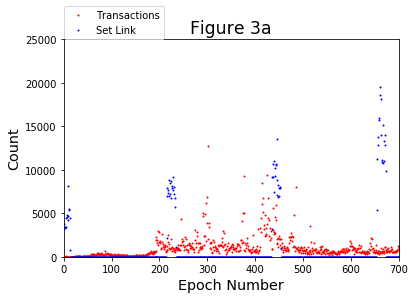

In [8]:
transactions_file = '../data/finalSets/dynamic/jan2013-trans-lcc-noself-uniq-{0}.txt'
link_changes_file = '../data/finalSets/dynamic/jan2013-newlinks-lcc-sorted-uniq-t{0}.txt'
epoch_length, transactions = get_epoch_length(transactions_file)
link_changes = read_link_changes_files(link_changes_file)


transactions_per_epoch = calculate_events_per_epoch(epoch_length, transactions)
link_changes_per_epoch = calculate_events_per_epoch(epoch_length, link_changes)
lc_per_epoch_list = dict_to_list(link_changes_per_epoch, 801)

matplotlib.pyplot.figure()
matplotlib.pyplot.title('Figure 3a', size='xx-large')
matplotlib.pyplot.ylabel('Count', size='x-large')
matplotlib.pyplot.xlabel('Epoch Number', size='x-large')
matplotlib.pyplot.axis([0,700,0,25000])

matplotlib.pyplot.plot(range(1, 801), transactions_per_epoch.values(), 'ro', markersize=1, linewidth=1, label='Transactions')
matplotlib.pyplot.plot(range(1, 801), lc_per_epoch_list, 'bo', markersize=1, linewidth=1, label='Set Link')
matplotlib.pyplot.legend(loc=(0,1), scatterpoints=10)


## 3b
The x-axis is the epoch number with epochs calculated as above. The y-axis is the number of stabilization messages for that epoch. The number of stabilization messages can be determined from the cnet-stab.txt file which tracks stabilization messages per epoch. All of these runs use 2 attempts and 3 landmarks.

### Run simulations

In [99]:
for step in range(0,9):
    run_dynamic(0, silentwhispers, 2, 3, step)
    run_dynamic(0, speedymurmurs, 2, 3, step)
print('Done.')

Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Running: java -cp bin/ treeembedding.tests.Dynamic 0 7 7
Run exists. Skipping...
Running: java -cp bin/ treeembedding.tests.Dynamic 0 7 8
Done.


### Generate plots from data

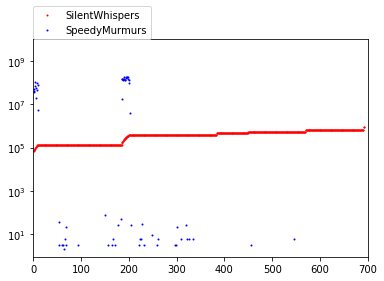

In [106]:
stab_file = '/cnet-stab.txt'

sw_stab_messages_list = []
sm_stab_messages_list = []
sw_stab_messages_dict = {}
sm_stab_messages_dict = {}
for step in range(0,9):
    sw_file_path = get_dynamic_data_path(silentwhispers, 3, 2, step) + stab_file
    sm_file_path = get_dynamic_data_path(speedymurmurs, 3, 2, step) + stab_file

    # create dict of stab message values for both sw and sm
    new_dict_sw = convert_kv_file_to_dict(sw_file_path)
    new_dict_sm = convert_kv_file_to_dict(sm_file_path)

    sw_stab_messages_dict = merge_dicts(new_dict_sw, sw_stab_messages_dict)
    sm_stab_messages_dict = merge_dicts(new_dict_sm, sm_stab_messages_dict)

sw_stab_messages_list = dict_to_list(sw_stab_messages_dict, 801)
sm_stab_messages_list = dict_to_list(sm_stab_messages_dict, 801)

matplotlib.pyplot.yscale('log')
matplotlib.pyplot.axis([0,700,0,1e+10])
matplotlib.pyplot.plot(range(1, 801), sw_stab_messages_list, 'ro', markersize=1, linewidth=1, label='SilentWhispers')
matplotlib.pyplot.plot(range(1, 801), sm_stab_messages_list, 'bo', markersize=1, linewidth=1, label='SpeedyMurmurs')
matplotlib.pyplot.legend(loc=(0,1), scatterpoints=10)

## 3c
The x-axis is the epoch number with epochs calculated as above. The y-axis is the ratio of the success rate of SpeedyMurmurs or SilentWhispers to the success rate of Ford-Fulkerson. The lines in the plot are represented as a moving average over 50 epochs. All of these runs use 2 attempts and 3 landmarks.

### Run simulations

In [100]:
for step in range(0,9):
    run_dynamic(0, silentwhispers, 2, 3, step)
    run_dynamic(0, speedymurmurs, 2, 3, step)
    run_dynamic(0, maxflow, 2, 3, step)
print('Done.')

Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Running: java -cp bin/ treeembedding.tests.Dynamic 0 10 1
Run exists. Skipping...
Run exists. Skipping...
Running: java -cp bin/ treeembedding.tests.Dynamic 0 10 2
Run exists. Skipping...
Run exists. Skipping...
Running: java -cp bin/ treeembedding.tests.Dynamic 0 10 3
Run exists. Skipping...
Run exists. Skipping...
Running: java -cp bin/ treeembedding.tests.Dynamic 0 10 4
Run exists. Skipping...
Run exists. Skipping...
Running: java -cp bin/ treeembedding.tests.Dynamic 0 10 5
Run exists. Skipping...
Run exists. Skipping...
Running: java -cp bin/ treeembedding.tests.Dynamic 0 10 6
Run exists. Skipping...
Run exists. Skipping...
Running: java -cp bin/ treeembedding.tests.Dynamic 0 10 7
Run exists. Skipping...
Run exists. Skipping...
Running: java -cp bin/ treeembedding.tests.Dynamic 0 10 8
Done.


### Generate plots from data

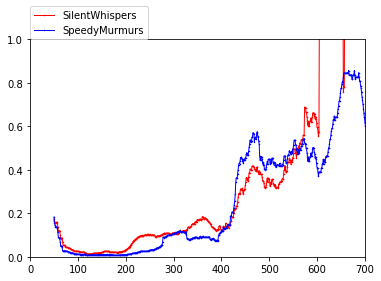

In [113]:
filename = '/cnet-succR.txt'

sw_succr_list = []
sm_succr_list = []
sw_succr_dict = {}
sm_succr_dict = {}
m_succr_dict = {}
for step in range(0, 9):
    m_file_path = get_dynamic_data_path(maxflow, 3, 2, step) + filename
    sw_file_path = get_dynamic_data_path(silentwhispers, 3, 2, step) + filename
    sm_file_path = get_dynamic_data_path(speedymurmurs, 3, 2, step) + filename

    # get succR for SW for each epoch
    sw_new_dict = convert_kv_file_to_dict(sw_file_path)
    sm_new_dict = convert_kv_file_to_dict(sm_file_path)
    m_new_dict = convert_kv_file_to_dict(m_file_path)
    
    sw_succr_dict = merge_dicts(sw_new_dict, sw_succr_dict)
    sm_succr_dict = merge_dicts(sm_new_dict, sm_succr_dict)
    m_succr_dict = merge_dicts(m_new_dict, m_succr_dict)

# update SW dict by dividing each value by the corresponding value in the M dict
for k,v in sw_succr_dict.items():
    if k in m_succr_dict:
        if m_succr_dict[k] == 0:
            sw_succr_dict[k] = 1
        else:
            sw_succr_dict[k] = v/m_succr_dict[k]

# update SM dict by dividing each value by the corresponding value in the M dict
for k,v in sm_succr_dict.items():
    if k in m_succr_dict:
        if m_succr_dict[k] == 0:
            sm_succr_dict[k] = 1
        else:
            sm_succr_dict[k] = v/m_succr_dict[k]

sw_succr_list = dict_to_list(sw_succr_dict, 801)
sm_succr_list = dict_to_list(sm_succr_dict, 801)

matplotlib.pyplot.axis([0,700,0,1])
matplotlib.pyplot.plot(range(50, 801), running_mean(sw_succr_list, 50), 'r*-', markersize=1, linewidth=1, label='SilentWhispers')

matplotlib.pyplot.plot(range(50, 801), running_mean(sm_succr_list, 50), 'b*-', markersize=1, linewidth=1, label='SpeedyMurmurs')
matplotlib.pyplot.legend(loc=(0,1), scatterpoints=10)



# Plot topology

## Define graph

In [9]:
topology_file = '../data/finalSets/static/ripple-lcc.graph'

G = read_graph_file(topology_file)

Skipping metadata, line: 1
Skipping metadata, line: 2
Skipping metadata, line: 3
Skipping metadata, line: 4
Skipping metadata, line: 5
Skipping metadata, line: 6
Skipping metadata, line: 7
node_id: 0
node_id: 1
node_id: 2
node_id: 3
node_id: 4
node_id: 5
node_id: 6
node_id: 7
Done


# Performance Under Attack

## Success ratio vs. Number of attackers

### Generate list of configurations

In [6]:
import simulation_utils as su

config_dict_list_srvna_sm = []
config_dict_list_srvna_sw = []
for data_set in range(0, 10):
    for alg in [su.speedymurmurs, su.silentwhispers]:
    # for alg in [silentwhispers]:
        for attackers in range(0, 30001, 5000):
        # for attackers in range(30000, 30001, 5000):
            config = f'''
data_set_name: full-{data_set}
base: ../data/finalSets/static
topology: ripple-lcc.graph
link_weights: ripple-lcc.graph_CREDIT_LINKS
transaction_set: sampleTr-{data_set}.txt
simulation_type: static
force_overwrite: false
routing_algorithm: "{alg}"
attempts: 1
trees: 3
attack_properties:
    attackers: {attackers}
    attacker_selection: "random"
    attack_type: drop_all
iterations: 1
'''
            if alg == su.speedymurmurs:
                config_dict_list_srvna_sm.append(su.parse_config(config))
            elif alg == su.silentwhispers:
                config_dict_list_srvna_sw.append(su.parse_config(config))



### Plot results

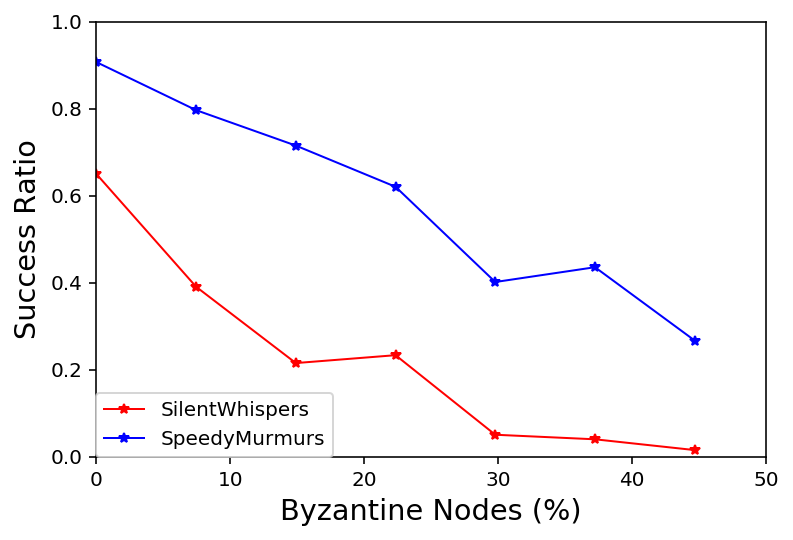

In [13]:
key = 'CREDIT_NETWORK_SUCCESS'
static_node_count = 67149

silentwhispers_data = su.extract_from_singles_config(config_dict_list_srvna_sw, key, "attack_properties", "attackers")
speedymurmurs_data = su.extract_from_singles_config(config_dict_list_srvna_sm, key, "attack_properties", "attackers")

matplotlib.pyplot.figure()
#matplotlib.pyplot.title('Drop Percentage Attack (100% drop rate)', size='xx-large')
matplotlib.pyplot.ylabel('Success Ratio', size='x-large')
matplotlib.pyplot.xlabel('Byzantine Nodes (%)', size='x-large')
matplotlib.pyplot.axis([0,50,0.0,1.0])

%config InlineBackend.figure_format ='retina'
perc = [i/static_node_count*100 for i in range(0,30001, 5000)]
matplotlib.pyplot.plot(perc, silentwhispers_data, 'r*-', markersize=5, linewidth=1, label='SilentWhispers')
matplotlib.pyplot.plot(perc, speedymurmurs_data, 'b*-', markersize=5, linewidth=1, label='SpeedyMurmurs')
matplotlib.pyplot.legend(loc=(0,0), scatterpoints=10)